In [1]:
from nilearn import plotting

ValueError: Trying to re-register the builtin cmap 'bwr'.

# Parameters

In [3]:
import os
from cneuromod_embeddings.dypac_utils import get_root_data

subject = "sub-03"
state = 256

# Set up file names... where to find the data.
path_data = get_root_data('models')
bg_img = os.path.join(path_data, f"{subject}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz")
parcels = os.path.join(path_data, f"dypac{state}_{subject}.nii.gz")
mask = os.path.join(path_data, f"mask_{subject}.nii.gz")

# Grey matter mask

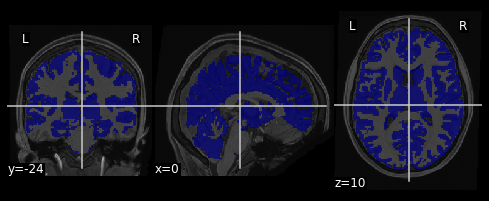

In [6]:
from nilearn.image import index_img
plotting.plot_roi(mask, bg_img=bg_img, resampling_interpolation='nearest')

# Loading parcels

In [7]:
from nilearn.image import load_img
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask, detrend=False, smoothing_fwhm=0)
components = masker.fit_transform(parcels)
components.shape

/home/pbellec/env/cneuromod_embeddings/lib/python3.6/site-packages/nilearn/image/image.py:214: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  .format(fwhm))


(255, 131536)

# Inter-parcel similarity and clustering

Number of clusters found 30


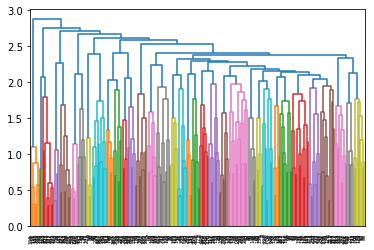

In [72]:
import numpy as np
from nilearn.connectome import ConnectivityMeasure
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

conn = np.squeeze(ConnectivityMeasure(kind='correlation').fit_transform([components.transpose()]))

# That's the hierarchical clustering step
hier = linkage(conn, method='average', metric='euclidean') # scipy's hierarchical clustering
# HAC proceeds by iteratively merging brain regions, which can be visualized with a tree
res = dendrogram(hier, get_leaves=True) # Generate a dendrogram from the hierarchy

# the order of merging above give us a good order to visualize the matrix
order = res.get('leaves') # Extract the order on parcels from the dendrogram

# We can cut the tree at whatever distance we choose
part = np.squeeze(cut_tree(hier, n_clusters=30)) # Cut the hierarchy
print(f"Number of clusters found {np.max(part) + 1}")

# Group parcels into clusters

(<AxesSubplot:title={'center':'inter-parcel similarity'}>,
 Text(0.5, 1.0, 'inter-parcel similarity'))

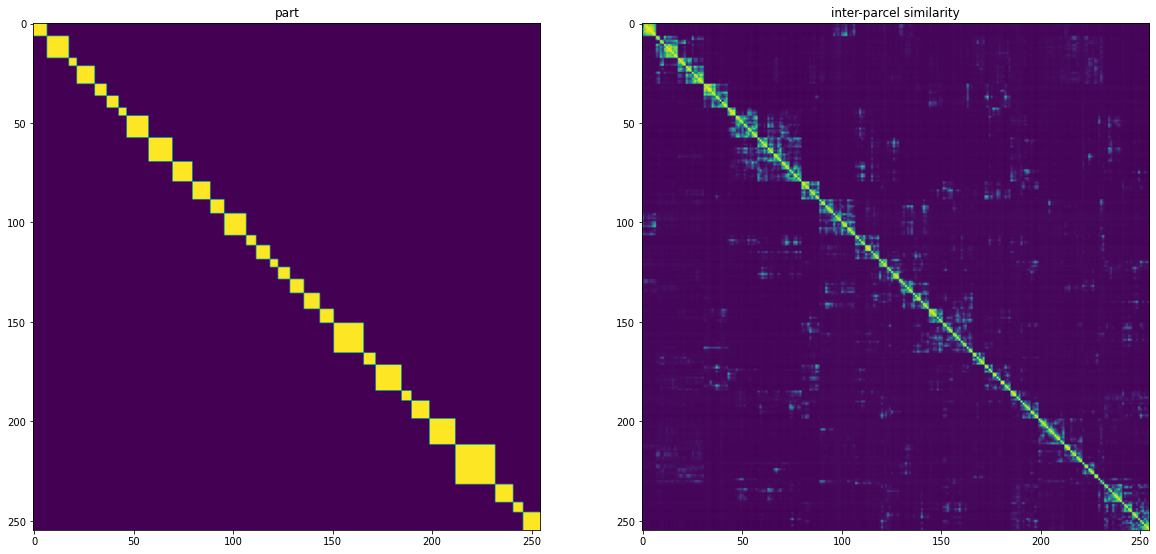

In [73]:
# Generate correlation matrix between parcels
from nilearn.connectome import ConnectivityMeasure
conn = np.squeeze(ConnectivityMeasure(kind='correlation').fit_transform([components.transpose()]))

# Another way to represent the clusters is an adjacency matrix A
# A(i,j) = 1 if i and j are in the same cluster, and 0 otherwise
def part2adj(part):
    part = np.reshape(part, [part.shape[0], 1])
    adj = np.repeat(part, part.shape[0], 1) == np.repeat(part.transpose(), part.shape[0], 0)
    return adj.astype(int)

import matplotlib.pyplot as plt
width_fig = 20
fig = plt.figure(figsize=(width_fig, width_fig * 0.5))
# Let's look at the adjacency matrix
# alongside the connectivity matrix, after reordering
plt.subplot(1,2,1), plt.imshow(part2adj(part[order])), plt.title('part')
plt.subplot(1,2,2), plt.imshow(conn[order, :][:, order]), plt.title('inter-parcel similarity')

# Cluster table

In [74]:
import pandas as pd
n_cluster = np.max(part) + 1
table = pd.DataFrame(columns=['parcel', 'size', 'homogeneity', 'label'])
for num_c in range(n_cluster):
    hom = np.mean(conn[part==num_c, :][:, part==num_c])
    siz = np.sum(part==num_c)
    table.loc[num_c] = [num_c, siz, hom, '']
pd.set_option("display.max_rows", None)
table

,parcel,size,homogeneity,label
0,0,7,0.455512,
1,1,20,0.111728,
2,2,13,0.204034,
3,3,9,0.324158,
4,4,6,0.488187,
5,5,7,0.515669,
6,6,4,0.814249,
7,7,15,0.188078,
8,8,7,0.458494,
9,9,11,0.367892,


# Labels
subject='sub-03', state=256, n_clusters=30

In [52]:
table['label'].loc[0]  = ['visual']
table['label'].loc[1]  = ['thalami', 'hippocampi', 'cerebellum']
table['label'].loc[2]  = ['ventral sensorimotor']
table['label'].loc[3]  = ['salience']
table['label'].loc[4]  = ['medial default-mode']
table['label'].loc[5]  = ['visual']
table['label'].loc[6]  = ['temporal']
table['label'].loc[7]  = ['attentional']
table['label'].loc[8]  = ['visual']
table['label'].loc[9]  = ['visual']
table['label'].loc[10] = ['cerebellum']
table['label'].loc[11] = ['?']
table['label'].loc[12] = ['attentional']
table['label'].loc[13] = ['sensorimotor']
table['label'].loc[14] = ['temporal pole', 'medial frontal', 'angular gyrus']
table['label'].loc[15] = ['frontal']
table['label'].loc[16] = ['frontal', 'angular gyrus']
table['label'].loc[17] = ['cardiac']
table['label'].loc[18] = ['salience']
table['label'].loc[19] = ['sensorimotor']
table['label'].loc[20] = ['striatum']
table['label'].loc[21] = ['?']
table['label'].loc[22] = ['attentional']
table['label'].loc[23] = ['cardiac']
table['label'].loc[24] = ['visual', 'dorsal stream']
table['label'].loc[25] = ['attentional']
table['label'].loc[26] = ['language']
table['label'].loc[27] = ['attentional']
table['label'].loc[28] = ['visual']
table['label'].loc[29] = ['cardiac']

# Visualize clusters

In [105]:
num_p = 30
width_fig = 20
list_parcel = np.nonzero(part == num_p)[0]
n_comp = len(list_parcel)
n_rows = int(np.ceil(n_comp / 3))
fig = plt.figure(figsize=(width_fig, n_comp))

for num, parcel in enumerate(list_parcel):
    ax_plot = plt.subplot(n_rows, 3, num + 1)
    plotting.plot_stat_map(
        masker.inverse_transform(components[parcel, :]), 
        display_mode="ortho",
        axes=ax_plot,
        threshold=0.1,
        vmax=1,
        colorbar=False,
        draw_cross=False,
        title=f"parcel {parcel}"
    )

<Figure size 1440x0 with 0 Axes>